## Bachelor Thesis - Informatik

### Variante 2 :
### Multiclass-Klassifizierung mit 2D Convolutional Neuronal Network
***



<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage den folgenden Datensatz :

[https://github.com/michidk/myo-dataset]

###### ☑️ Der Datensatz wurde neu aufbereitet, siehe dazu --> [Link](Preprocessing.ipynb)

###### ☑️ 10 Testpersonen, nachfolgend Subjekte genannt, haben in 6 Sitzungen jeweils 10 Wiederholungen ausgeführt

###### ☑️ Alle Personen haben die folgenden drei Gesten in gleicher Position ausgeführt :

<img src="./Images/paper.png" width="150">         <img src="./Images/rock.png" width="150">        <img src="./Images/scissors.png" width="150">      

##### ▶️ Installation notwendiger Python-Bibliotheken
***

In [14]:
##############################################################
#      Dieses Notebook wurde mit Python 3.9.13 getestet      #
#                                                            #
#           Andere Versionen haben teilweise                 #
#           Kompatbilitätsprobleme verursacht                #
#                                                            #
#      This Notebook was tested with Python 3.9.13           #
#                                                            #
#              Other Versions can cause                      #
#                Compatibilityproblems                       #
#                                                            #
##############################################################

In [15]:
##############################################################
# Achtung!! Die Konvertierung des Modells nach C++           #
#           funktioniert nur mit Tensorflow <=2.15.1         #
#           Keras 3 funktioniert nicht!                      #
#                                                            #
# Attention! Converting the model to C++ ist only working    #
#            with Tensorflow <=2.15.1                        #
#            Keras 3 will not work!                          #
##############################################################
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Gizmo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


##### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [16]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore

import tensorflow as tf # type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten # type: ignore
from tensorflow import keras # type: ignore

import logging
tf.get_logger().setLevel(logging.ERROR)


##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
***

In [17]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Subjekte und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Papier
# Label 1 --> Stein
# Label 2 --> Schere


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
subject1 = []
subject2 = []
subject3 = []
subject4 = []
subject5 = []
subject6 = []
subject7 = []
subject8 = []
subject9 = []
subject10 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2']:
    subject1.append(pd.read_csv('./Datasets/Concatenated/S1L' + label + '.csv', sep=',', header=None))     
    subject1[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject2.append(pd.read_csv('./Datasets/Concatenated/S2L' + label + '.csv', sep=',', header=None))     
    subject2[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject3.append(pd.read_csv('./Datasets/Concatenated/S3L' + label + '.csv', sep=',', header=None))     
    subject3[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject4.append(pd.read_csv('./Datasets/Concatenated/S4L' + label + '.csv', sep=',', header=None))     
    subject4[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject5.append(pd.read_csv('./Datasets/Concatenated/S5L' + label + '.csv', sep=',', header=None))     
    subject5[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject6.append(pd.read_csv('./Datasets/Concatenated/S6L' + label + '.csv', sep=',', header=None))     
    subject6[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject7.append(pd.read_csv('./Datasets/Concatenated/S7L' + label + '.csv', sep=',', header=None))     
    subject7[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject8.append(pd.read_csv('./Datasets/Concatenated/S8L' + label + '.csv', sep=',', header=None))     
    subject8[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject9.append(pd.read_csv('./Datasets/Concatenated/S9L' + label + '.csv', sep=',', header=None))     
    subject9[int(label)][8] = int(label)

for label in ['0', '1', '2']:
    subject10.append(pd.read_csv('./Datasets/Concatenated/S10L' + label + '.csv', sep=',', header=None))     
    subject10[int(label)][8] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
subject1 = pd.concat([df for df in subject1], axis=0).reset_index(drop=True)
subject2 = pd.concat([df for df in subject2], axis=0).reset_index(drop=True)
subject3 = pd.concat([df for df in subject3], axis=0).reset_index(drop=True)
subject4 = pd.concat([df for df in subject4], axis=0).reset_index(drop=True)
subject5 = pd.concat([df for df in subject5], axis=0).reset_index(drop=True)
subject6 = pd.concat([df for df in subject6], axis=0).reset_index(drop=True)
subject7 = pd.concat([df for df in subject7], axis=0).reset_index(drop=True)
subject8 = pd.concat([df for df in subject8], axis=0).reset_index(drop=True)
subject9 = pd.concat([df for df in subject9], axis=0).reset_index(drop=True)
subject10 = pd.concat([df for df in subject10], axis=0).reset_index(drop=True)

sub_1 = pd.DataFrame(subject1)
sub_5 = pd.concat([subject1, subject2, subject3, subject4, subject5])
sub_10 = pd.concat([subject1, subject2, subject3, subject4, subject5, subject6, subject7, subject8, subject9, subject10])

##### ▶️ Umwandlung in geeignete Datenstrukturen
***

In [18]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs


##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = sub_10[sub_10.columns[-1]]
 

##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
classes = np.unique(Labels)
print("Classes Shape:",classes.shape)


##############################################################
# Sensorwerte der Gesten auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Features = sub_10.drop(8, axis=1).copy()


##############################################################
# Zerteile Gesamtdaten in Einzelpakete mit jeweils 16 Zeilen #
# Datentyp Python List                                       #
##############################################################
Features = split_dataframe(Features, 8, 'last')
Labels = split_dataframe(Labels, 8, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_features = len(Features)-1
Features = Features[:l_features]

l_labels = len(Labels)-1
Labels = Labels[:l_labels]


##############################################################
# Konvertiere die Listen in Numpy-Arrays als Float32         #
# Dann eine Dimension hinzu als Channel                      #
# Datentyp Numpy-Array                                       #
##############################################################
Features = np.array(Features).astype('float32')
Features = Features.reshape(-1,8)

#sc = MinMaxScaler(feature_range=(-30,30))
#sc = MinMaxScaler()
#sc = StandardScaler()

#Features = sc.fit_transform(Features)

Features = Features.reshape(-1,8,8)
Features = np.expand_dims(Features, -1)


##############################################################
# Zuerst alle Label-Arrays nach 1D konvertieren              #
# Dann eine Dimension hinzu als Channel                      #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
Labels = np.array(Labels).astype('int')
Labels = Labels[:,1]
Labels = np.expand_dims(Labels, -1)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Features Shape: ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Labels Shape:", Labels.shape)


Classes Shape: (3,)
Features Shape:  (65249, 8, 8, 1)
Labels Shape: (65249, 1)


### ▶️ Datensatz aufteilen in Training- und Test-Daten
***

In [19]:
##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 3                                                  #
##############################################################
num_classes = 3


##############################################################
# Eingangswerte im Format 8 x 8 x 1
##############################################################
input_shape = (8, 8, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.15, random_state = 100) # type: ignore
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state=100)

X_test_file = X_test.reshape(-1,64)
X_test_file = X_test_file[:1000]

X_val_file = X_val.reshape(-1,64)
X_val_file = X_val_file[:500]

##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("X_validate Vectorform:", X_val.shape)
print("y_train Vectorform:", y_train.shape)
print("y_validate Vectorform:", y_val.shape)
print("y_test Vectorform:", y_test.shape)
print()
print(Features.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_test_file = y_test[:1000]
y_val_file = y_val[:500]

np.savetxt('../data/X_test.csv', X_test_file, delimiter=",", fmt='%f')
np.savetxt('../data/y_test.csv', y_test_file, delimiter=",", fmt='%d')

np.savetxt('../data/X_val.csv', X_val_file, delimiter=",", fmt='%f')
np.savetxt('../data/y_val.csv', y_val_file, delimiter=",", fmt='%d')


X_train Vectorform: (47141, 8, 8, 1)
X_test Vectorform: (9788, 8, 8, 1)
X_validate Vectorform: (8320, 8, 8, 1)
y_train Vectorform: (47141, 1)
y_validate Vectorform: (8320, 1)
y_test Vectorform: (9788, 1)

65249 Gesamtwerte
47141 Trainingswerte
9788 Testwerte


#### ▶️ Modellarchitektur
***

In [20]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch = 1 #working

filters1 = 32
filters2 = 32

neurons = 16

epochs = 8

initializer='glorot_uniform'
padding='same'

##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(Input(shape=input_shape, batch_size=batch))

model.add(Conv2D(filters1, (2,2), strides=(2,2) ,padding = padding, activation='relu', name='conv1'))
model.add(MaxPool2D(1, 1, name='pool1'))

model.add(Conv2D(filters2, (2,2), strides=(2,2) , padding = padding, activation='relu', name='conv2'))
model.add(MaxPool2D(1, 1, name='pool2'))

model.add(Flatten())
model.add(Dense(neurons, activation= 'relu'))

model.add(Dense(num_classes, activation='softmax'))

# Modellparameter ausgeben
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (1, 4, 4, 32)             160       
                                                                 
 pool1 (MaxPooling2D)        (1, 4, 4, 32)             0         
                                                                 
 conv2 (Conv2D)              (1, 2, 2, 32)             4128      
                                                                 
 pool2 (MaxPooling2D)        (1, 2, 2, 32)             0         
                                                                 
 flatten_1 (Flatten)         (1, 128)                  0         
                                                                 
 dense_2 (Dense)             (1, 16)                   2064      
                                                                 
 dense_3 (Dense)             (1, 3)                   

In [21]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',    
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),   
    epochs=epochs,   
)

Epoch 1/8
1474/1474 [==============================] - 6s 3ms/step - loss: 0.9269 - accuracy: 0.5219 - val_loss: 0.8800 - val_accuracy: 0.5500
Epoch 2/8
1474/1474 [==============================] - 4s 3ms/step - loss: 0.8556 - accuracy: 0.5682 - val_loss: 0.8545 - val_accuracy: 0.5645
Epoch 3/8
1474/1474 [==============================] - 4s 3ms/step - loss: 0.8340 - accuracy: 0.5855 - val_loss: 0.8361 - val_accuracy: 0.5864
Epoch 4/8
1474/1474 [==============================] - 4s 3ms/step - loss: 0.8219 - accuracy: 0.5945 - val_loss: 0.8303 - val_accuracy: 0.5925
Epoch 5/8
1474/1474 [==============================] - 5s 3ms/step - loss: 0.8127 - accuracy: 0.6016 - val_loss: 0.8217 - val_accuracy: 0.5992
Epoch 6/8
1474/1474 [==============================] - 4s 3ms/step - loss: 0.8036 - accuracy: 0.6084 - val_loss: 0.8181 - val_accuracy: 0.5960
Epoch 7/8
1474/1474 [==============================] - 4s 3ms/step - loss: 0.7977 - accuracy: 0.6114 - val_loss: 0.8257 - val_accuracy: 0.5980

#### ▶️ Exportiere das Modell nach C++
***

- Dieses Modell funktioniert auf dem ESP32S3

In [22]:
##############################################################
# Konvertiere Modell in Format für Headerfile                #
# Inhalt ab/inklusive der Zeile "#pragma once"               #
# in eine neue Datei mit Namen "Model.h" kopieren            #
##############################################################
from eloquent_tensorflow import convert_model
print(convert_model(model))


#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

// automatically configure network
#define TF_NUM_INPUTS 64
#define TF_NUM_OUTPUTS 3
#define TF_NUM_OPS 5

/**
 * Call this function to register the ops
 * that have been detected
 */
template<class TF>
void registerNetworkOps(TF& nn) {
    nn.resolver.AddReshape();
    nn.resolver.AddFullyConnected();
    nn.resolver.AddMaxPool2D();
    nn.resolver.AddConv2D();
    nn.resolver.AddSoftmax();
    
}




// model data
const unsigned char tfModel[28828] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x80, 

#### ▶️ Ausgabe der Verlustfunktion für Training und Validation
***

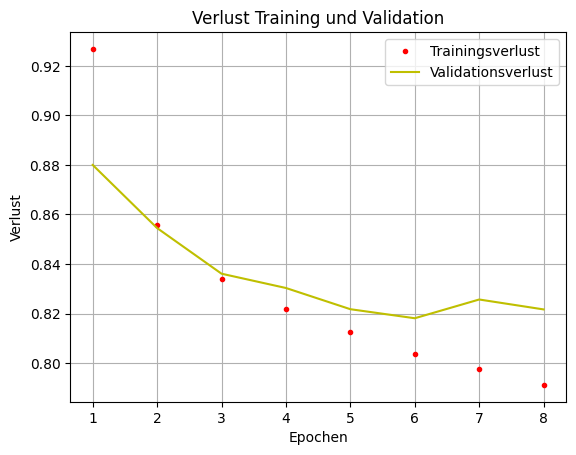

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'y', label='Validationsverlust')
plt.title('Verlust Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.grid()
plt.legend()
plt.savefig('./Images/Loss.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Ausgabe der Genauigkeit für Training und Validation
***

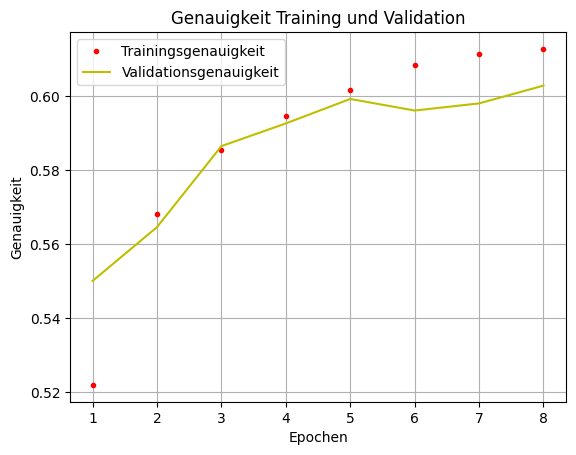

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'r.', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'y', label='Validationsgenauigkeit')
plt.title('Genauigkeit Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.grid()
plt.legend()
plt.savefig('./Images/Accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Modell auf Testdaten anwenden und evaluieren
***

In [25]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8216545581817627
Test accuracy: 0.6027644276618958


#### ▶️ Metriken zur Beurteilung der Modellqualität 
***

306/306 [==============================] - 1s 2ms/step


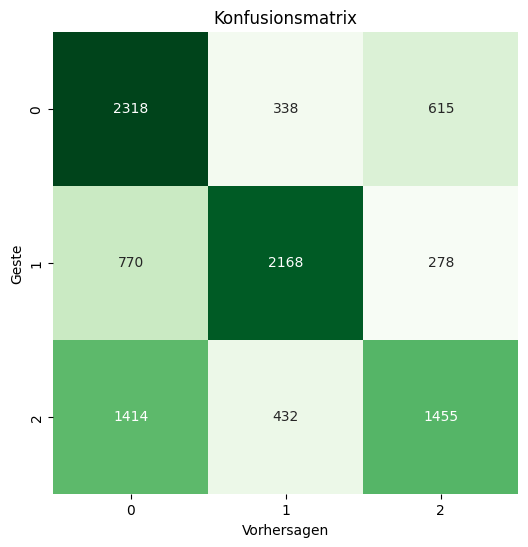

              precision    recall  f1-score   support

           0       0.51      0.71      0.60      3271
           1       0.74      0.67      0.70      3216
           2       0.62      0.44      0.52      3301

    accuracy                           0.61      9788
   macro avg       0.62      0.61      0.61      9788
weighted avg       0.62      0.61      0.60      9788



In [26]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))